In [23]:
import random
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from icecream import ic
import math

from collections import defaultdict

In [146]:
#CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])

CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])

In [147]:
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    # For each pair (c1, c2), the code calculates the geodesic distance between their geographical 
    # coordinates using geopy.distance.geodesic(), which computes the shortest path over the Earth's surface.
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km        #converts the calculated distance to kilometers

#### Setting initial population and cost function

In [148]:
# Generate initial population of paths
# each individual is a valid TSP path represented by a sequence of cities ending back at the starting city, 0.
def initial_population(pop_size, n_cities):
    start_city = 0  # Define the starting city index, all the individuals in the population MUST have the same!
    return [
        [start_city] + random.sample(range(1, n_cities), n_cities - 1) + [start_city] 
        for _ in range(pop_size)
    ]

# [0] is appended to the end of each sequence to enforce a circular route, ensuring each path returns to the starting city (index 0).

In [149]:
# Calculate cost of TSP route
def tsp_cost(tsp):
    return sum(DIST_MATRIX[tsp[i], tsp[i+1]] for i in range(len(tsp) - 1))

#### Setting mutation algorithms

In [150]:
# Mutation functions ensuring circular path
def swap_mutation(path):
    # from the range of valid indices (excluding the first and last indices, which are fixed as the starting city)
    i, j = random.sample(range(1, len(path) - 1), 2)
    path[i], path[j] = path[j], path[i]
    path[-1] = path[0]
    return path

In [151]:
def scramble_mutation(path, num_selected=5):
    # Ensure num_selected is at least 2 and does not exceed the number of cities minus 2
    num_selected = max(2, min(num_selected, len(path) - 2))
    
    # Randomly select num_selected distinct indices from the valid range
    selected_indices = random.sample(range(1, len(path) - 1), num_selected)

    # Extract the elements at the selected indices
    elements_to_scramble = [path[i] for i in selected_indices]

    # Shuffle only the selected elements
    random.shuffle(elements_to_scramble)

    # Place the shuffled elements back into their respective positions in the path
    for i, index in zip(elements_to_scramble, selected_indices):
        path[index] = i

    # Ensure the path remains circular
    path[-1] = path[0]
    
    return path

In [152]:
def insert_mutation(path, num_selected=5):
    # Always select 2 distinct indices from the valid range
    selected_indices = random.sample(range(1, len(path) - 1), 2)

    # Sort the selected indices to work with them in order
    selected_indices.sort()

    # Get the indices
    first_index = selected_indices[0]
    second_index = selected_indices[1]

    # Get the element to insert (from the second index)
    element_to_insert = path[second_index]

    # Remove the element to insert from its original position
    path.pop(second_index)

    # Insert the element right after the first index
    path.insert(first_index + 1, element_to_insert)
    
    path[-1] = path[0]  # Ensure the path remains circular
    return path

In [153]:
def inversion_mutation(path):
    i, j = sorted(random.sample(range(1, len(path) - 1), 2))
    path[i:j+1] = reversed(path[i:j+1])
    path[-1] = path[0]
    return path

#### Setting crossover algorithms

In [154]:
def inver_over_crossover(parent1, parent2):
    # Ensure the length of parents is the same
    assert len(parent1) == len(parent2)

    # Trimmed versions of the parents (exclude the first and last elements)
    trimmed_parent1 = parent1[1:-1]
    trimmed_parent2 = parent2[1:-1]
    n = len(trimmed_parent1)

    # Select a gene from trimmed_parent1
    selected_gene_index = random.randint(0, n - 1)  # extremes included
    selected_gene = trimmed_parent1[selected_gene_index]

    # Find the position of the selected gene in trimmed_parent2
    selected_gene_in_parent2_index = trimmed_parent2.index(selected_gene)

    # Find the consecutive gene in trimmed_parent2
    consecutive_gene_in_parent2_index = selected_gene_in_parent2_index + 1 if selected_gene_in_parent2_index + 1 < n else 0
    consecutive_gene = trimmed_parent2[consecutive_gene_in_parent2_index]

    # Start building the offspring (trimmed version)
    trimmed_offspring = [None] * n

    # Copy the selected gene and consecutive gene from trimmed_parent2 to trimmed_offspring
    trimmed_offspring[selected_gene_in_parent2_index] = selected_gene
    trimmed_offspring[consecutive_gene_in_parent2_index] = consecutive_gene

    # Locate the index of the consecutive gene in trimmed_parent1
    consecutive_gene_in_parent1_index = trimmed_parent1.index(consecutive_gene)

    # Copy the genes between the selected gene and consecutive gene in reverse order
    reverse_segment = (
        trimmed_parent1[selected_gene_index + 1:consecutive_gene_in_parent1_index][::-1]
        if selected_gene_index < consecutive_gene_in_parent1_index
        else trimmed_parent1[consecutive_gene_in_parent1_index + 1:selected_gene_index][::-1]
    )

    # Insert the reversed segment into trimmed_offspring after the consecutive gene
    current_index = consecutive_gene_in_parent2_index + 1
    for gene in reverse_segment:
        # Wrap back to the start of trimmed_offspring if we reach the end
        if current_index >= n:
            current_index = 0
        trimmed_offspring[current_index] = gene
        current_index += 1

    # Fill any remaining None values in trimmed_offspring with genes from trimmed_parent1
    for gene in trimmed_parent1:
        # Only copy the gene if it's not already in trimmed_offspring
        if gene not in trimmed_offspring:
            for i in range(n):
                if trimmed_offspring[i] is None:
                    trimmed_offspring[i] = gene
                    break  # Move to the next gene in trimmed_parent1 once placed

    # Add the fixed start and end elements from parent1 to create the final offspring
    offspring = [parent1[0]] + trimmed_offspring + [parent1[-1]]

    return offspring


In [ ]:
"""parent1 = [0, 1, 3, 2, 4, 5, 0]  # Circular path representation
parent2 = [0, 3, 4, 1, 2, 5, 0]

offspring = inver_over_crossover(parent1, parent2)
print(offspring)"""

[0, 4, 5, 1, 2, 3, 0]


In [155]:
def cycle_crossover(parent1, parent2):
    # Ensure the length of parents is the same
    assert len(parent1) == len(parent2)

    # Trimmed versions of the parents (exclude the first and last elements for a circular route)
    trimmed_parent1 = parent1[1:-1]
    trimmed_parent2 = parent2[1:-1]
    n = len(trimmed_parent1)

    # Choose two loci within the trimmed segment
    l1, l2 = sorted(random.sample(range(n), 2))

    # Start creating offspring by copying a segment from parent1
    trimmed_offspring = [None] * n
    trimmed_offspring[l1:l2 + 1] = trimmed_parent1[l1:l2 + 1]       #l1 to l2, inclusive

    # Fill the remaining values from parent2
    current_index = 0

    # Fill with unused values from trimmed_parent2
    for city in trimmed_parent2:
        if city not in trimmed_offspring:
            # Find the next available None position in trimmed_offspring
            while trimmed_offspring[current_index] is not None:
                current_index = (current_index + 1) % len(trimmed_offspring)  # Wrap around to the start if at the end
            # Place the city in the first available None spot
            trimmed_offspring[current_index] = city
            current_index = (current_index + 1) % len(trimmed_offspring)  # Move to the next position

    # Add the fixed start and end points to form a valid TSP route
    offspring = [parent1[0]] + trimmed_offspring + [parent1[0]]

    return offspring


#### Genetic Algorithm

In [156]:
""" Pick up 1/5 of the population, select the fittest 10, if possible. """

# Parent selection using tournament selection
def tournament_selection(population, costs, tournament_size=None, num_to_return=10):
    # Determine the tournament size as 1/5 of the population
    if tournament_size is None:
        tournament_size = max(1, len(population) // 5)  # Ensure at least one individual is sampled

    # Randomly sample individuals
    selected = random.sample(list(zip(population, costs)), tournament_size)

    # Sort selected individuals by their costs
    selected_sorted = sorted(selected, key=lambda x: x[1])  # Sort by cost (x[1] is the cost)

    # Return the top 'num_to_return' individuals with the lowest costs
    return [ind[0] for ind in selected_sorted[:num_to_return]]

In [157]:
MIN_TEMP = 1e-17

# Main Genetic Algorithm with Self-Adaptive Cooling Rate
def genetic_algorithm_with_adaptive_sa(cities, population_size, generations, initial_temp=1000, initial_cooling_rate=0.99, adapt_factor=0.1):
    population = initial_population(population_size, len(cities))
    best_cost_history = []  # To store the best cost for each generation

    temperature = initial_temp
    cooling_rate = initial_cooling_rate
    previous_best_cost = float('inf')  # keeps track of the best cost from the previous generation.

    for generation in tqdm(range(generations)):
        costs = [tsp_cost(ind) for ind in population]
        current_best_cost = min(costs)  # Get the best cost of the current generation
        best_cost_history.append(current_best_cost)  # Record the best cost of this generation

        # Adapt cooling rate based on improvement
        if current_best_cost < previous_best_cost:
            cooling_rate *= (1 - adapt_factor)  # Slow down cooling (less aggressive)
        else:
            cooling_rate *= (1 + adapt_factor)  # Speed up cooling (more aggressive)

        # Ensure cooling rate stays within reasonable bounds [0.8, 1.1]
        cooling_rate = max(0.8, min(cooling_rate, 1.1))  # Keep cooling rate within 0.8 to 1.1

        # Update previous best cost for the next iteration
        previous_best_cost = current_best_cost

        # Parent selection: Pick 1/5 of the population and select the fittest 10
        selected_parents = tournament_selection(population, costs)

        # Generate new offspring
        offspring = []

        while len(offspring) < population_size * 1.5:  # Create the new population size
            # Randomly select two parents from the selected parents
            parent1 = random.choice(selected_parents)
            parent2 = random.choice(selected_parents)

            # Perform crossover to produce new individuals
            crossover_type = random.choice([cycle_crossover, inver_over_crossover])
            child = crossover_type(parent1, parent2)

            # --- Apply mutation based on simulated annealing acceptance
            # Calculate the cost of the child before mutation
            initial_cost = tsp_cost(child)

            # Randomly choose a mutation type to apply
            mutation_type = random.choice([inversion_mutation, insert_mutation, scramble_mutation, swap_mutation])
            mutated_child = mutation_type(child)

            # Calculate the cost of the mutated child
            mutated_cost = tsp_cost(mutated_child)

            # Decide whether to accept the mutation
            if mutated_cost < initial_cost:
                # Accept mutation if the cost is lower
                child = mutated_child
            else:
                # Accept the worse solution with a probability based on temperature
                acceptance_probability = math.exp(-(mutated_cost - initial_cost) / temperature)
                if random.random() < acceptance_probability:
                    child = mutated_child

            offspring.append(child)

        # Cooling schedule: "Reduce" the temperature after each generation
        if temperature > MIN_TEMP:
            temperature *= cooling_rate

        # `Generational model applied` + `Elitist strategy`:
        # Keep the top 10% of the current population for the next generation
        elite_size = int(0.10 * population_size)
        elite_population = sorted(zip(population, costs), key=lambda x: x[1])[:elite_size]  # retain till elite_size elements

        # Keep the top 60% of the current offspring for the next generation
        num_offspring_to_retain  = int(0.60 * len(offspring))
        selected_offspring = sorted(zip(offspring, [tsp_cost(ind) for ind in offspring]), key=lambda x: x[1])[:num_offspring_to_retain]  # retain till elite_size elements
        
        # Combine the current elite population with the selected offspring
        population = [ind[0] for ind in elite_population] + [ind[0] for ind in selected_offspring]

        assert len(population) == population_size

    # Return final population, best cost, and history of best costs
    return population[0], tsp_cost(population[0]), best_cost_history

#### Plot results

In [158]:
def plot_best_cost(best_cost_history):
    plt.plot(best_cost_history, marker='o')
    plt.title('Best TSP Cost Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best TSP Cost')
    plt.grid()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Total Cost (km): 1345.5449564733112
Total Steps (generations): 50


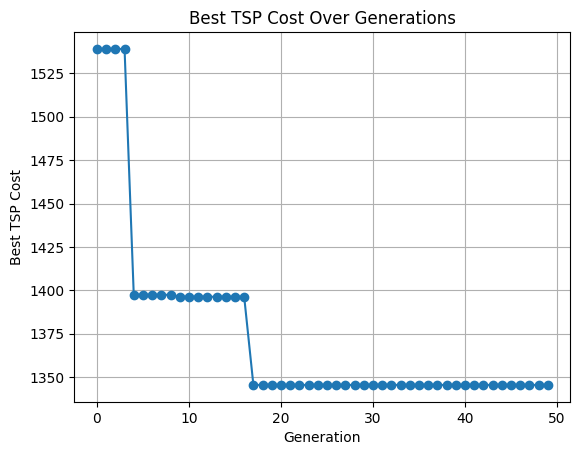

In [159]:
GENERATIONS = 50
POPULATION_SIZE = 10

last_path, total_cost, best_cost_history = genetic_algorithm_with_adaptive_sa(CITIES, POPULATION_SIZE, GENERATIONS)
#print("Last Path:", last_path)
print("Total Cost (km):", total_cost)
print("Total Steps (generations):", GENERATIONS)
plot_best_cost(best_cost_history)


In [162]:
def plot_tsp_path(cities_df, path):
    # Extract coordinates of cities based on their index
    x = cities_df['lon'].iloc[path].values  # Get longitudes
    y = cities_df['lat'].iloc[path].values   # Get latitudes

    # Close the loop by adding the starting city again
    x = list(x) + [x[0]]  # Add starting city again to close the loop
    y = list(y) + [y[0]]  # Add starting city again to close the loop

    plt.figure(figsize=(20, 20))
    plt.plot(x, y, marker='o')
    plt.title('Traveling Salesman Problem Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()

    # Annotate the cities with their names
    for i, (x_pos, y_pos) in zip(path, zip(x, y)):
        plt.annotate(cities_df['name'].iloc[i], (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center')

    plt.show()

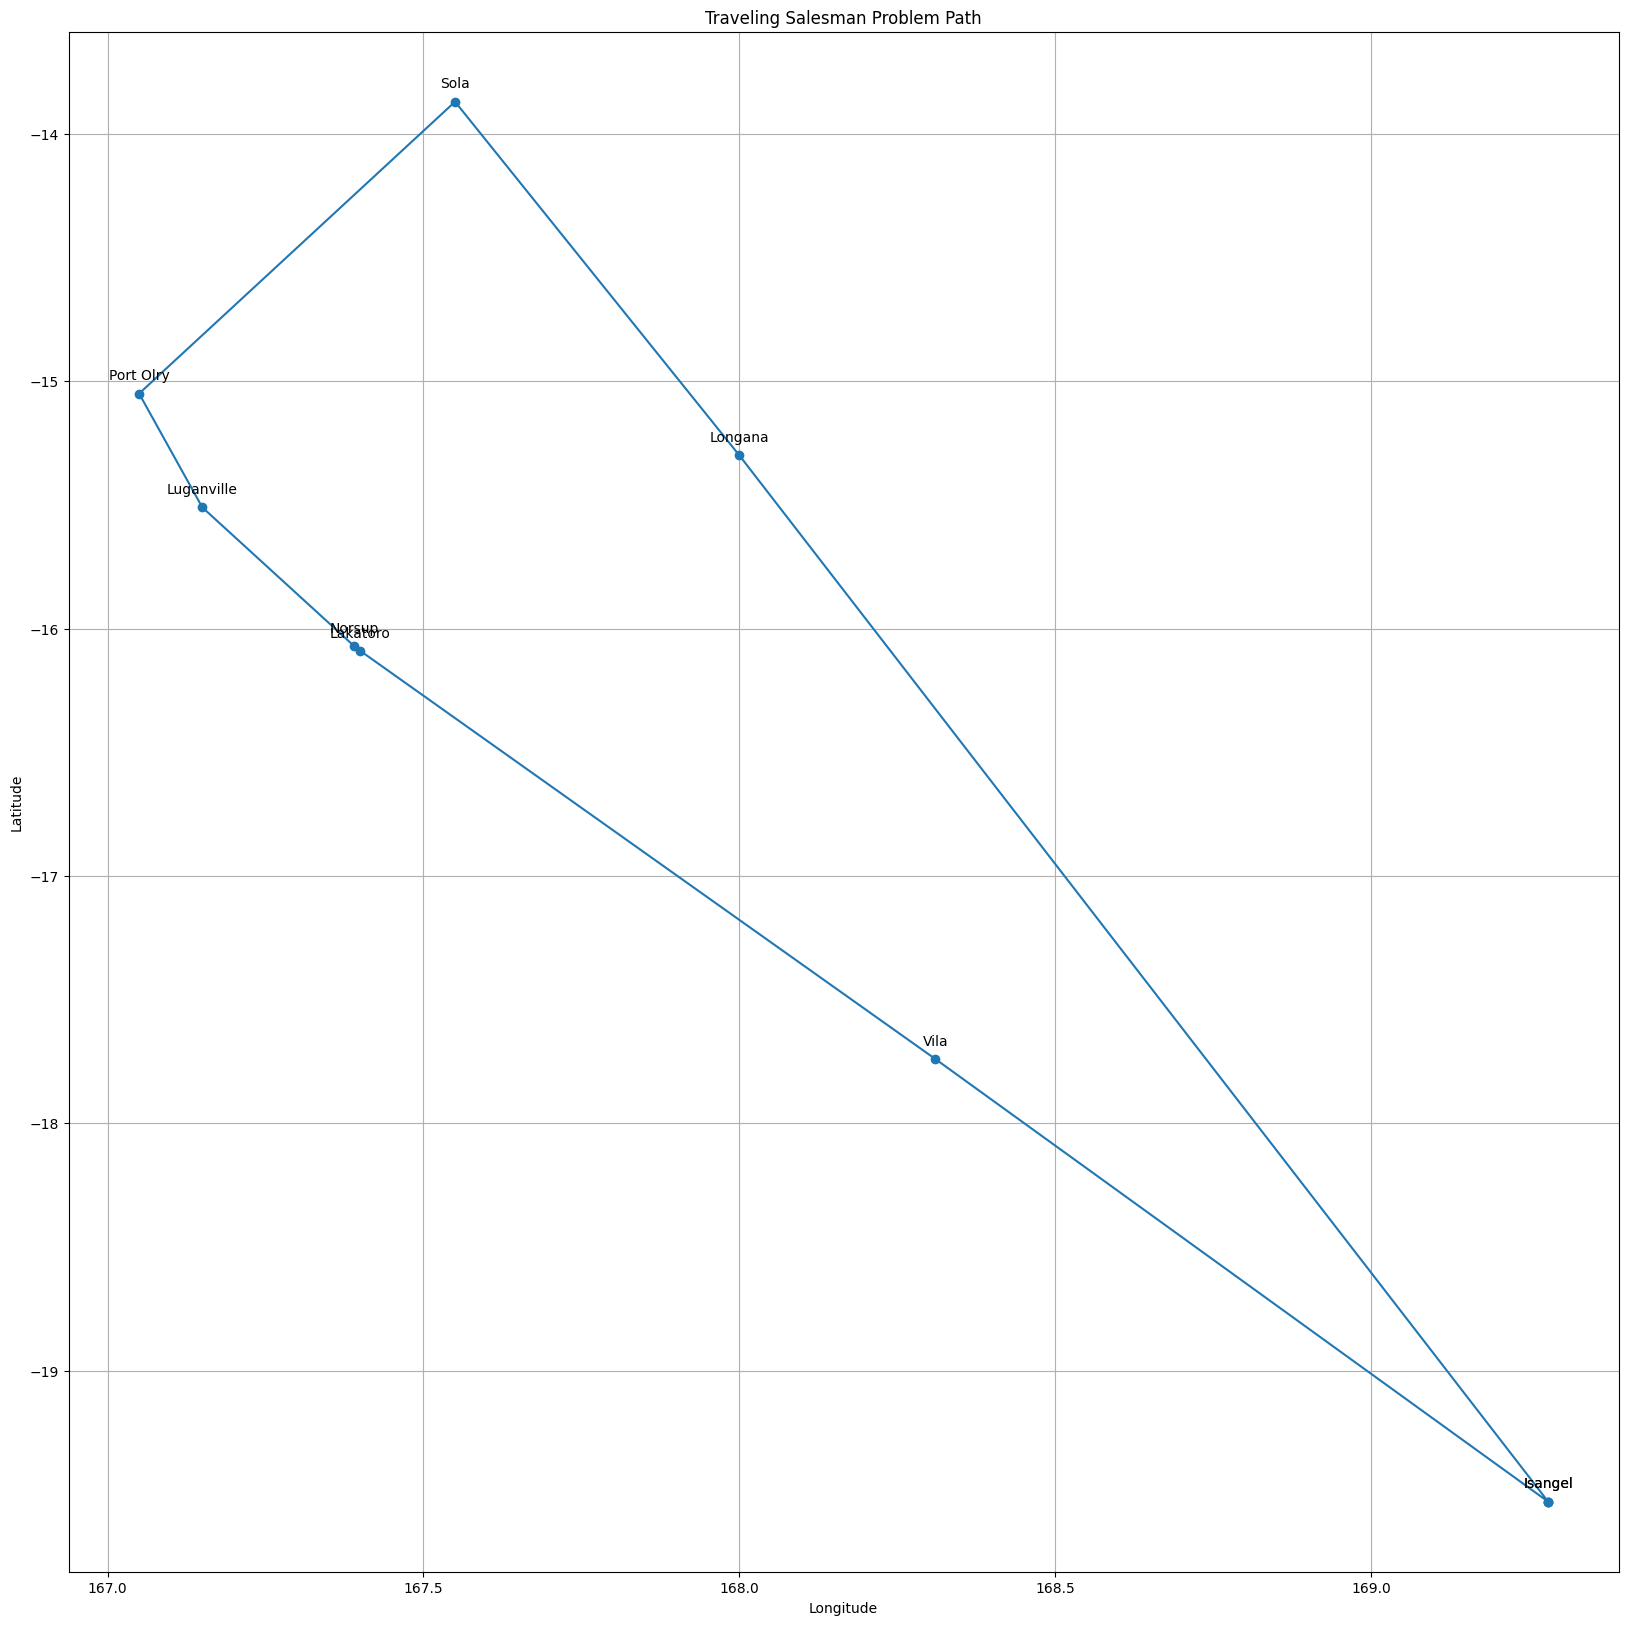

In [163]:
plot_tsp_path(CITIES, last_path)